In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-oyighj21
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-oyighj21
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=4e5ee3cae60ba93edad962b77347798fda9d7fa3cc2a320087c5775e605c149d
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqc154xj/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [ ]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cstring>
#include <ctime>
#define N 1024*12
// Device Kernel
__global__ void min(float *A, float *S)
 {
   	//holds intermediates in shared memory reduction
    	__shared__ int sdata[N];

    	int tid=threadIdx.x;
    	int i = blockIdx.x * blockDim.x + threadIdx.x;
	sdata[tid]=A[i];
        __syncthreads();

  	for (unsigned int s=1; s>blockDim.x; s *=2) 
  	{
		if (tid %(2*s)==0) 
		{
		   if (sdata[tid] >sdata[tid + s]){
			 sdata[tid] = sdata[tid + s];
		}
	 	__syncthreads();
   	}	
		}	  

   	if(tid==0) 
		S[blockIdx.x]=sdata[0];

}

//host Function
float cpu_min(float *A) {

  float min;
  min=A[0];
     for(int i = 1; i < N; i++) {
          if(min>A[i]){
			    
				min=A[i];
		  }
    }

    
  return min;
  
} 
// host code
int main()
{
   
	size_t size = N * sizeof(float);
	
	FILE *f;
	f=fopen("min.txt","w");
	
	float S;
	clock_t start,stop;
	   
   	printf("\nName of the Model= Data Parallel Model\n");

	float* d_A;
	float* d_S;
        
        int threadsPerBlock;
	if (N<=1024) 
		threadsPerBlock=N;
	else 
		threadsPerBlock=1024;
		
    	int blocksPerGrid =(N + threadsPerBlock - 1) / threadsPerBlock;
	printf("\nblocksPerGrid=%d\n",blocksPerGrid);
	
	// Allocate input vectors h_A and h_B in host memory
	float* h_A = (float*)malloc(size);				
	float* h_S = (float*)malloc(sizeof(float)*blocksPerGrid);
	
	srand(time(NULL));
	// Initialize input vectors
	for(int i = 0; i < N; i++) 
     {					
     	h_A[i] =5+i;//rand()%100;
    	}

	cudaMalloc(&d_A, size);						
	cudaMalloc(&d_S, sizeof(float)*blocksPerGrid);
	
	// Copy vectors from host memory to device memory
	cudaError err1 =cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice); 
	if(err1!=cudaSuccess) {
      printf("CUDA error copying to Device: %s\n", cudaGetErrorString(err1));
    }		
	
 	//Parallel Computation
 	start = std::clock();
 	//Invoke kernal
    	min<<<blocksPerGrid,threadsPerBlock>>>(d_A, d_S);
	
	stop = std::clock();		
	 
   	long int time=stop - start;
    	// Copy result from device memory to host memory
    	cudaError err =cudaMemcpy(h_S, d_S, sizeof(float)*blocksPerGrid, cudaMemcpyDeviceToHost);
	if(err!=cudaSuccess) {
      printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
    }
     float b=h_S[0];
for(int i = 1; i < blocksPerGrid; i++) 
	{
       	if(h_S[i]<b)
		b=h_S[i];
	}
		printf("%f\t", b);
        
		
	
	//Storing in file	
      	for(int i=0;i<N;i++)
	{
		fprintf(f,"%f ",h_A[i]);              //if correctly computed, then all values must be N
		fprintf(f,"\n");
	}

	//write cuda result in file
	fprintf(f,"Cuda Result= %f ",b);
	
	printf("_________________________Parallel______________________________\n	\n");
	
	//print result on terminal
	printf("Cuda Result= %f ",b);
	
	printf("\n\nExecution Time of parallel Implementation= %ld (ms)\n",time);
	
	// Free device memory
	cudaFree(d_A);
	cudaFree(d_S);
        
	printf("\n_________________________Sequential____________________________________\n	");
	
  	//Sequential Computations
  	start = std::clock();
  	
  	//Invoke CPU function
  	S=cpu_min(h_A);
  						
  	stop = std::clock();
  	
  	//Storing in file
  	fprintf(f,"\nCPU Result= %f ",S);
	printf("\nCPU Result= %f ",S);
	
 	long int Stime=stop - start;
 	
  	printf("\n\nExecution Time of Sequential Implementation= %ld (ms)\n",Stime );
	printf("_______________________________________________________________________	");
    
 	int cores=2560; //teslaT4 SM=40 Core=2560


	//total  number of cores
   	printf("\n\nNo. of cores:%d\n",cores);
   	//Total cost is execution time * number of processors
   	printf("\nTotal cost=Execution Time * Number ofprocessors used = %ld",time*cores);
   	
   	float speedup = float(Stime)/float(time);
   	printf("\nSpeedUp = Squential Time/Parallel Time = %f",speedup);
   	
   	float efficiency = speedup/float(cores);
   	printf("\nEfficiency = SpeedUp/Number Of Processors Used =%f\n",efficiency);
   	
       //Based on the result.CSV file you have to draw graph
	FILE *f1;
	f1 = fopen("Result.csv","a");
	//fprintf(f1,"N,SERIAL_TIME,PARALLEL_TIME,TOTAL_COST,SPEEDUP,EFFICIENCY\n");
	fprintf(f1, "%d,%ld,%ld,%ld,%f,%f\n",N,Stime,time,time*cores,speedup,efficiency);
	//fprintf(f1,"--------------------------------------------------------------------------------------------------------------------\n");
	
	// Free host memory      
	free(h_S);  
	free(h_A);
}


Name of the Model= Data Parallel Model

blocksPerGrid=12
5.000000	_________________________Parallel______________________________
	
Cuda Result= 5.000000 

Execution Time of parallel Implementation= 15 (ms)

_________________________Sequential____________________________________
	
CPU Result= 5.000000 

Execution Time of Sequential Implementation= 28 (ms)
_______________________________________________________________________	

No. of cores:2560

Total cost=Execution Time * Number ofprocessors used = 38400
SpeedUp = Squential Time/Parallel Time = 1.866667
Efficiency = SpeedUp/Number Of Processors Used =0.000729



        N  SERIAL_TIME  PARALLEL_TIME  TOTAL_COST   SPEEDUP  EFFICIENCY
0    2048            6             15       38400  0.400000    0.000156
1    3072            8             15       38400  0.533333    0.000208
2    4096           11             21       53760  0.523810    0.000205
3    5120           12             15       38400  0.800000    0.000312
4    6144           14             17       43520  0.823529    0.000322
5    7168           20             15       38400  1.333333    0.000521
6    8192           19             15       38400  1.266667    0.000495
7    9216           21             16       40960  1.312500    0.000513
8   10240           24             15       38400  1.600000    0.000625
9   11264           25             17       43520  1.470588    0.000574
10  12288           28             15       38400  1.866667    0.000729


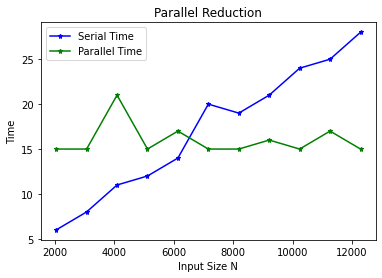

In [72]:
import pandas as pd
import matplotlib.pyplot as plt 
from plotly.offline import iplot
df = pd.read_csv("Result.csv") 
print(df)
plt.plot(df.N,df.SERIAL_TIME,"b*-",markersize=5, label="Serial Time")
plt.plot(df.N,df.PARALLEL_TIME,"g*-",markersize=5,label="Parallel Time")
plt.plot()
plt.xlabel("Input Size N")
plt.ylabel("Time")
plt.title("Parallel Reduction")
plt.legend()
plt.show()

        N  SERIAL_TIME  PARALLEL_TIME  TOTAL_COST   SPEEDUP  EFFICIENCY
0    2048            6             15       38400  0.400000    0.000156
1    3072            8             15       38400  0.533333    0.000208
2    4096           11             21       53760  0.523810    0.000205
3    5120           12             15       38400  0.800000    0.000312
4    6144           14             17       43520  0.823529    0.000322
5    7168           20             15       38400  1.333333    0.000521
6    8192           19             15       38400  1.266667    0.000495
7    9216           21             16       40960  1.312500    0.000513
8   10240           24             15       38400  1.600000    0.000625
9   11264           25             17       43520  1.470588    0.000574
10  12288           28             15       38400  1.866667    0.000729


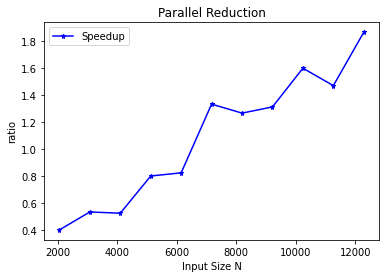

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from plotly.offline import iplot
df = pd.read_csv("Result.csv") 
print(df)
plt.plot(df.N,df.SPEEDUP,"b*-",markersize=5, label="Speedup")
plt.plot()
plt.xlabel("Input Size N")
plt.ylabel("ratio")
plt.title("Parallel Reduction")
plt.legend()
plt.show()

        N  SERIAL_TIME  PARALLEL_TIME  TOTAL_COST   SPEEDUP  EFFICIENCY
0    2048            6             15       38400  0.400000    0.000156
1    3072            8             15       38400  0.533333    0.000208
2    4096           11             21       53760  0.523810    0.000205
3    5120           12             15       38400  0.800000    0.000312
4    6144           14             17       43520  0.823529    0.000322
5    7168           20             15       38400  1.333333    0.000521
6    8192           19             15       38400  1.266667    0.000495
7    9216           21             16       40960  1.312500    0.000513
8   10240           24             15       38400  1.600000    0.000625
9   11264           25             17       43520  1.470588    0.000574
10  12288           28             15       38400  1.866667    0.000729


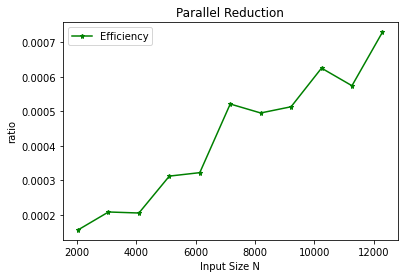

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from plotly.offline import iplot
df = pd.read_csv("Result.csv") 
print(df)
plt.plot(df.N,df.EFFICIENCY,"g*-",markersize=5,label="Efficiency")
plt.plot()
plt.xlabel("Input Size N")
plt.ylabel("ratio")
plt.title("Parallel Reduction")
plt.legend()
plt.show()